# Поиск структуры в данных от автопроизводителей

## Получение и изучение данных

### Поставленная задача и исходные данные

**Заказчик предоставил данные от автопроизводителей.**

**Цель: исследовать данные и разделить модели автомобилей на кластеры.**

**Описание данных**

Каждый объект в наборе данных — это характеристики модели автомобиля:

- `mpg` — потребление топлива (сколько миль проедет ваша машина на галлоне топлива),
- `cylinders` — количество цилиндров,
- `cubicinches` — объём двигателя (кубические дюймы),
- `hp` — мощность двигателя (лошадиные силы),
- `weightlbs` — вес автомобиля (фунты),
- `time-to-60` — время разгона до 60 миль/час,
- `year` — год выпуска,
- `brand` — страна-производитель автомобиля.


- В датасете известен целевой признак, по которому модели автомобилей делятся по кластерам. Это столбец `brand`, который принимает значения: *`[' US.', ' Europe.', ' Japan.']`*.

### Импорт библиотек и базовые настройки

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

### Чтение данных

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/cars.csv')
data_label = pd.read_csv('https://code.s3.yandex.net/datasets/cars_label.csv')

In [3]:
data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year
0,14.0,8.0,350,165.0,4209,12.0,1972.0
1,31.9,4.0,89,71.0,1925,14.0,1980.0
2,17.0,8.0,302,140.0,3449,11.0,1971.0
3,15.0,8.0,400,150.0,3761,10.0,1971.0
4,30.5,4.0,98,63.0,2051,17.0,1978.0


In [4]:
data_label.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8.0,350,165.0,4209,12.0,1972.0,US.
1,31.9,4.0,89,71.0,1925,14.0,1980.0,Europe.
2,17.0,8.0,302,140.0,3449,11.0,1971.0,US.
3,15.0,8.0,400,150.0,3761,10.0,1971.0,US.
4,30.5,4.0,98,63.0,2051,17.0,1978.0,US.


### Визуализация

Посмотрим на распределение автомобилей по странам

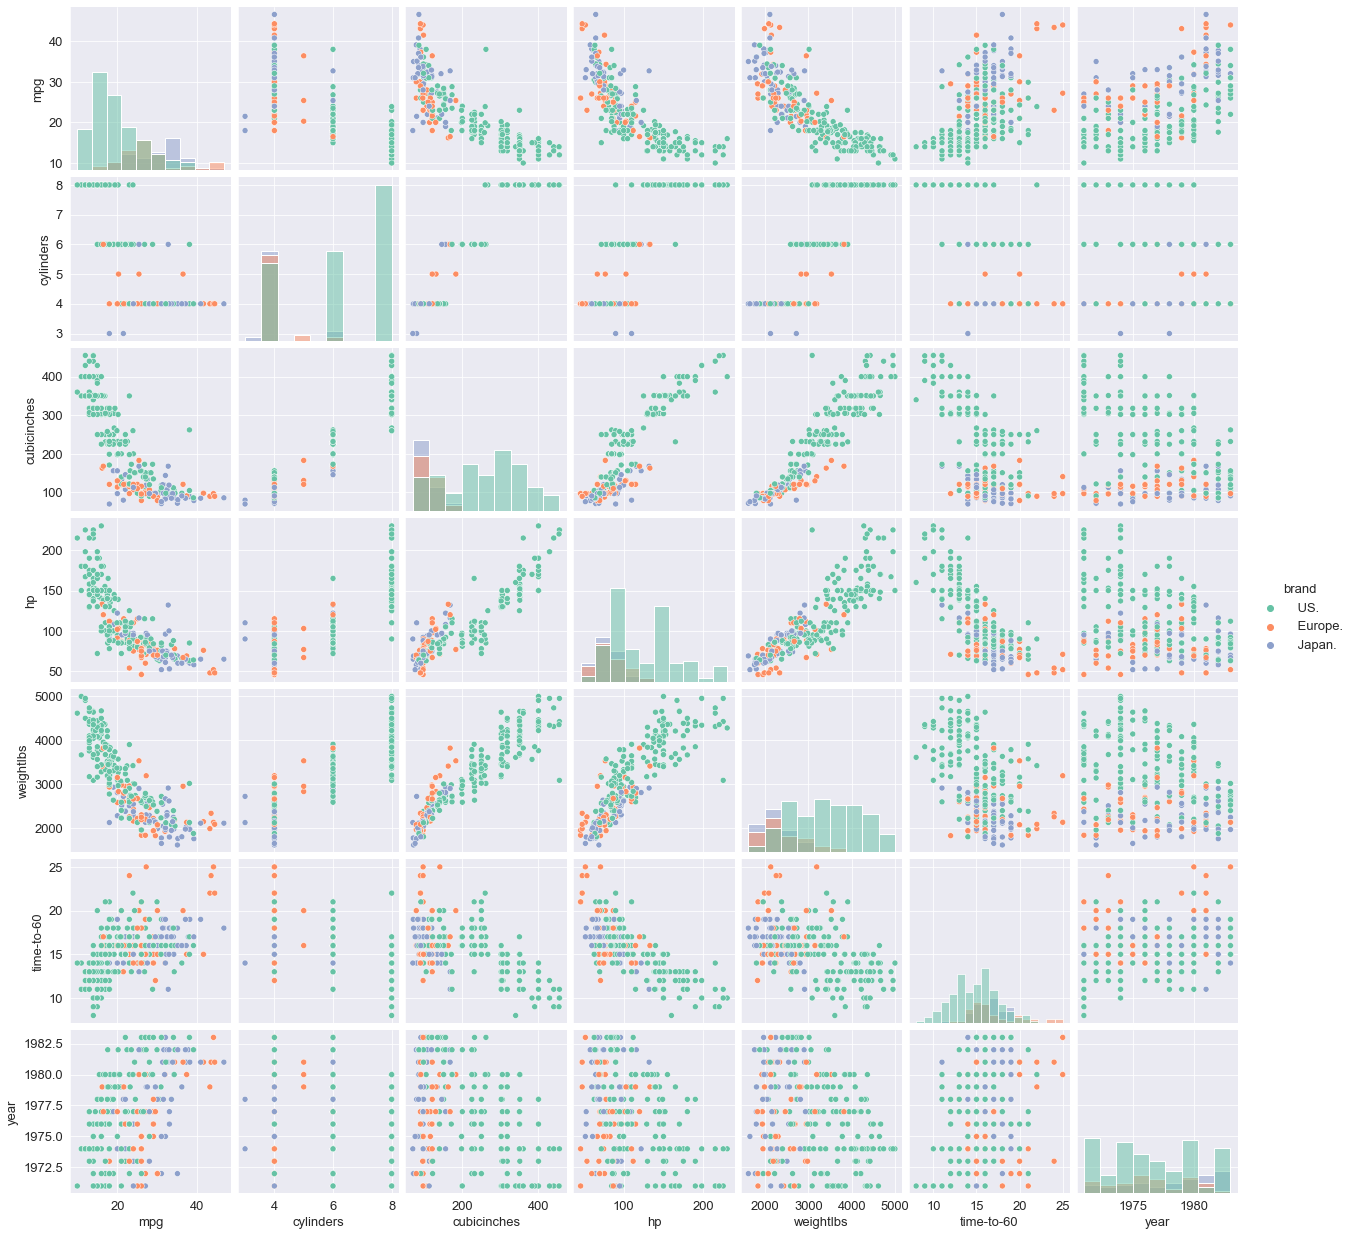

In [5]:
pairgrid = sns.pairplot(data_label, hue='brand', diag_kind='hist'); 

- На всех графиках для количества цилиндров выделяются три полосы точек.
- В паре признаков «количество цилиндров — расход топлива» американские автомобили заметно отделены от остальных.
- Признаки «год выпуска» и «время разгона» выглядят бесполезными: точки распределены по всей оси для каждой страны.
- На проекции признаков «мощность двигателя» и «вес автомобиля» видно, что дисперсия и среднее значение для американских автомобилей выше, а показатели японских и европейских близки.

---

Чтобы найти новые закономерности, обучим алгоритм *k-средних* без столбца о стране-производителе.

- Построим график метода локтя для количества кластеров от 1 до 10.
- Составим список `distortion` значений целевой функции для количества кластеров от 1 до 10.
- Для полученных значений целевой функции построим график метода локтя.

In [6]:
data_k = data.copy()

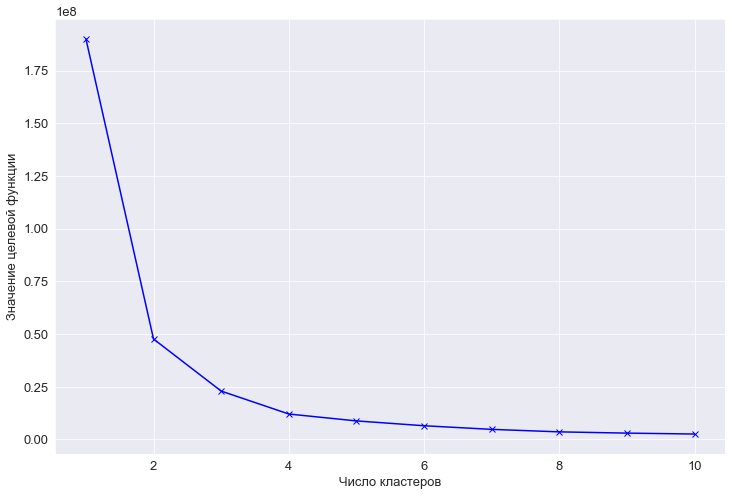

In [7]:
distortion = []
K = range(1, 11)
for k in K:
    model_k = KMeans(n_clusters=k, random_state=12345)
    model_k.fit(data_k)
    distortion.append(model_k.inertia_) 

plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

- Оптимальное количество кластеров - от 2 до 4, это не противоречит трём значениям столбца `brand`.

---

Посмотрим, какие 3 кластера выделит алгоритм *k-средних*.

Построим диаграмму `pairplot` для модели с тремя кластерами без отмеченных центроидов. Из-за особенностей версий *seaborn* нужно указать список признаков в функции `pairplot()`: `vars=data.columns[:-1]`. Последний признак — это номер кластера, его отображать не надо.

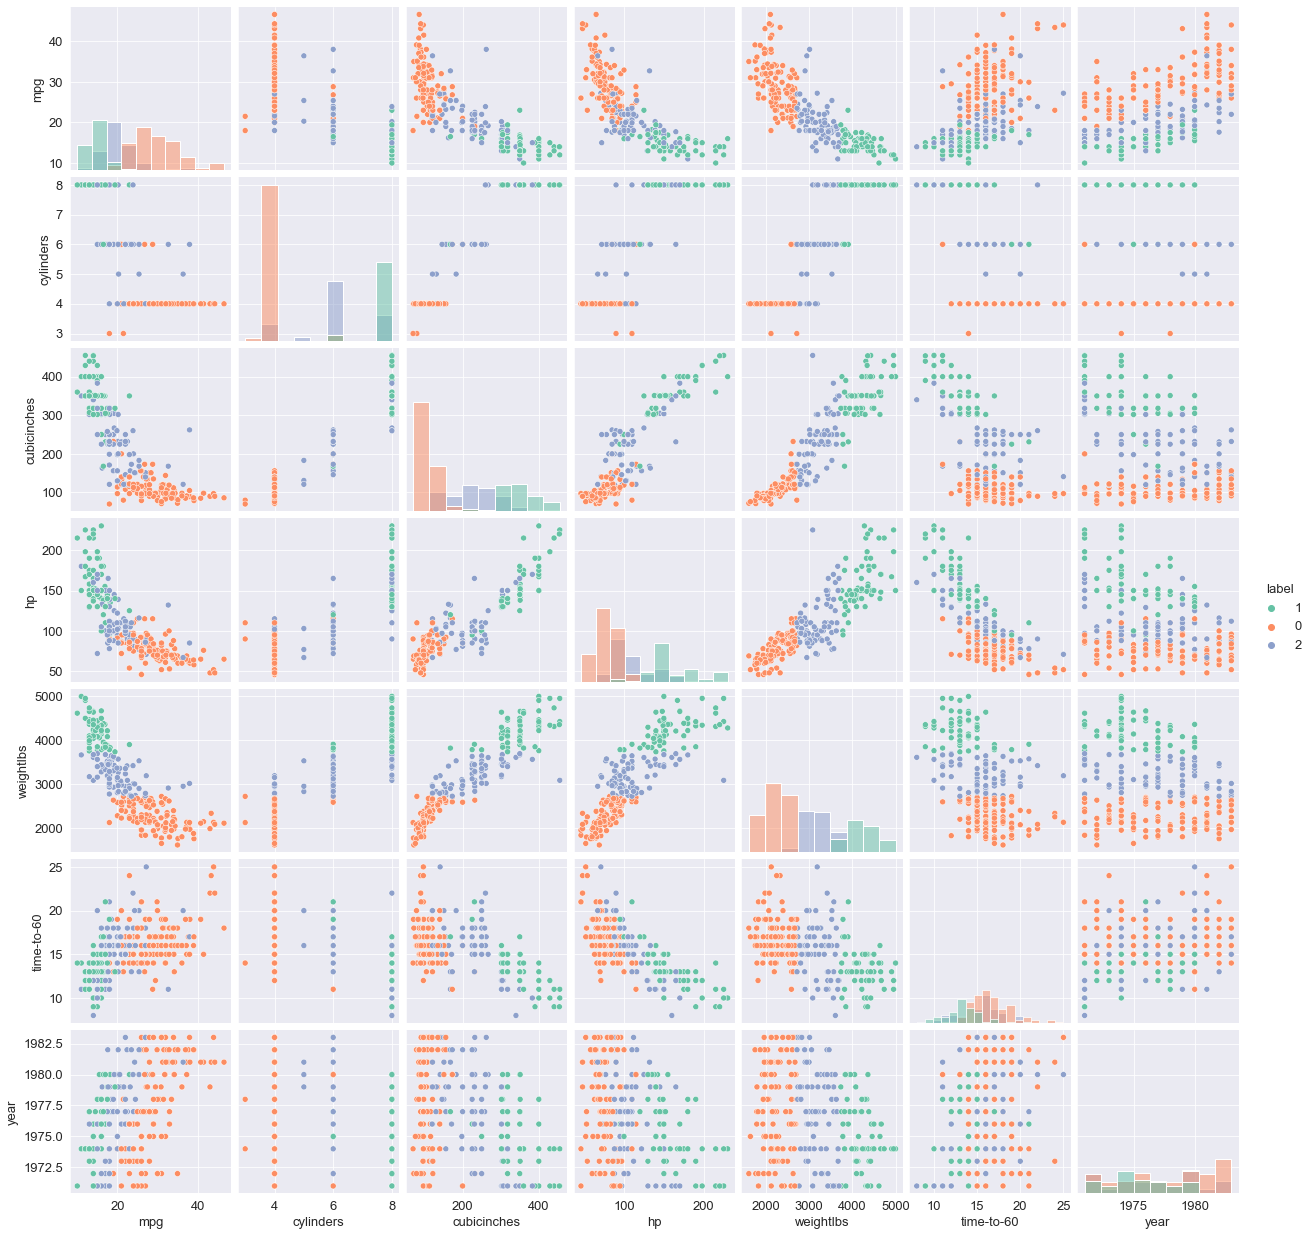

In [8]:
data_3 = data.copy()
model_3 = KMeans(n_clusters=3, random_state=12345)             # обучение модели для трёх кластеров пользователей
model_3.fit(data_3)

data_3['label'] = model_3.labels_.astype(str)

pairgrid = sns.pairplot(data_3, hue='label', vars=data_3.columns[:-1], diag_kind='hist'); 

- Распределения для трёх кластеров стали более похожими, чем по странам-производителям. Количество точек в каждом кластере примерно одинаковое.
- Скопления объектов для количества цилиндров оказались в разных кластерах: на них повлияли другие признаки.
- Столбцы `time-to-60` и `year` подтвердили свою бесполезность.

---

- Построим диаграмму `pairplot` с заливкой по столбцу `brand`.
- Добавим на график полученные центроиды.

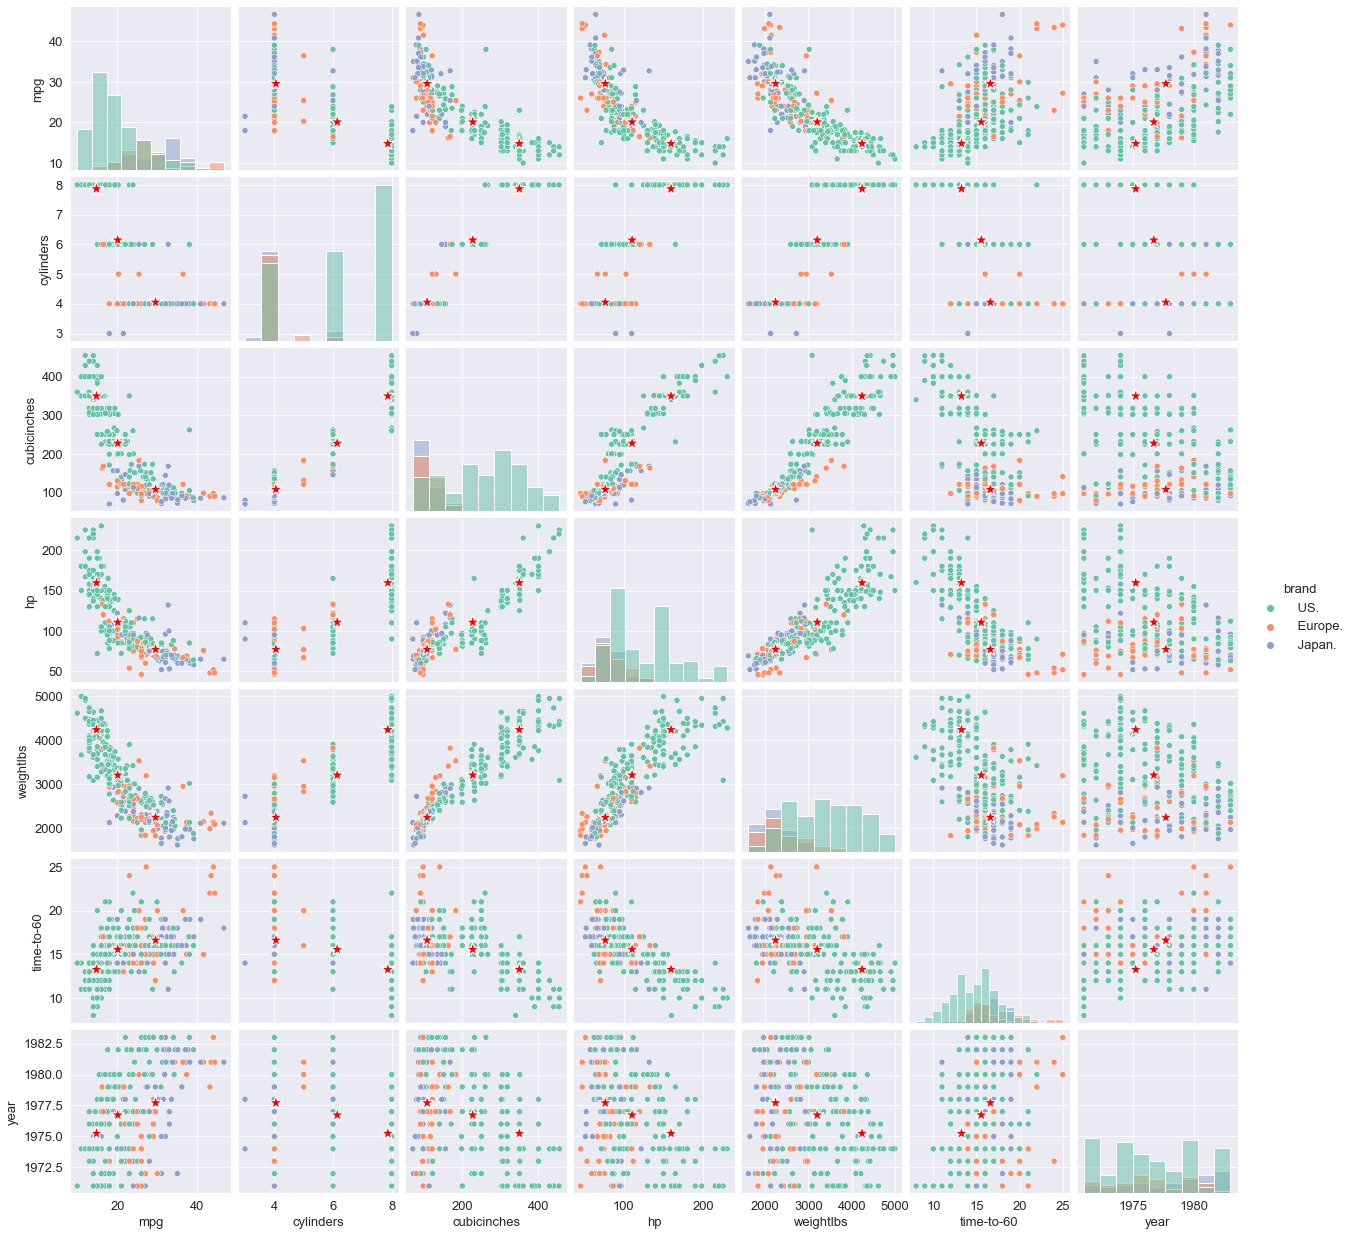

In [9]:
# Сформируем таблицу для дополнительного слоя 
centroids = pd.DataFrame(model_3.cluster_centers_, columns=data.columns)
 
# Построение графика
pairgrid = sns.pairplot(data_label, hue='brand', diag_kind='hist')
centroids['brand'] = 4 # Сформируем "заглушку"
pairgrid.data = centroids
pairgrid.map_offdiag(func=sns.scatterplot, s=200, marker='*', palette='flag');

- Есть смысл разделить кластер с брендом "US" на два - с большими двигателями, как у "Japan" (6 цилиндров) и очень большими (8 цилиндров).